# Import & Exploration

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler


In [2]:
file_path = 'data/melted.csv'
df = pd.read_csv(file_path)

df

,Unnamed: 0,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,date,price
0,0,Autonomous region in Muslim Mindanao,Basilan,Basilan,6.663056,122.136111,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,2020-01-15,36.80
1,1,Autonomous region in Muslim Mindanao,Basilan,Basilan,6.663056,122.136111,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,2020-02-15,36.80
2,2,Autonomous region in Muslim Mindanao,Basilan,Basilan,6.663056,122.136111,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,2020-03-15,36.80
3,3,Autonomous region in Muslim Mindanao,Basilan,Basilan,6.663056,122.136111,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,2020-04-15,36.80
4,4,Autonomous region in Muslim Mindanao,Basilan,Basilan,6.663056,122.136111,cereals and tubers,"Rice (regular, milled)",KG,actual,Retail,PHP,2020-05-15,36.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100135,100135,Region XIII,Surigao del Sur,Surigao del Sur,9.056504,126.196915,vegetables and fruits,Squashes,KG,actual,Retail,PHP,2024-08-15,32.50
100136,100136,Region XIII,Surigao del Sur,Surigao del Sur,9.056504,126.196915,vegetables and fruits,Squashes,KG,actual,Retail,PHP,2024-09-15,32.50
100137,100137,Region XIII,Surigao del Sur,Surigao del Sur,9.056504,126.196915,vegetables and fruits,Squashes,KG,actual,Retail,PHP,2024-10-15,35.63
100138,100138,Region XIII,Surigao del Sur,Surigao del Sur,9.056504,126.196915,vegetables and fruits,Squashes,KG,actual,Retail,PHP,2024-11-15,35.63


In [ ]:
# --- Convert Data Types ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# --- Validate Reasonable Values ---
valid_date = df['date'].notna() 
valid_start_date = (df['date'] >= pd.Timestamp('2020-03-01')) & (df['date'] <= pd.Timestamp('2025-03-20'))
valid_lat = df['latitude'].notna() & (df['latitude'] >= -90) & (df['latitude'] <= 90)
valid_lon = df['longitude'].notna() & (df['longitude'] >= -180) & (df['longitude'] <= 180)
valid_price = df['price'].notna() & (df['price'] >= 0)
all_valid = valid_date & valid_start_date & valid_lat & valid_lon & valid_price

# --- Create a New DataFrame with Only Valid Rows ---
df_cleaned = df[all_valid].copy()

print("Number of rows before cleaning:", len(df))
print("Number of rows after cleaning:", len(df_cleaned))


Number of rows before cleaning: 100140
Number of rows after cleaning: 96802


In [4]:
central_lat = 14.5995   # Example: Latitude for Manila, Philippines
central_lon = 120.9842  # Example: Longitude for Manila, Philippines

# Define the Haversine function to compute distance in kilometers
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

df_cleaned['distance_from_central'] = haversine_distance(central_lat, central_lon, df_cleaned['latitude'], df_cleaned['longitude'])

print(df_cleaned[['market', 'latitude', 'longitude', 'distance_from_central']].tail())

                 market  latitude   longitude  distance_from_central
100135  Surigao del Sur  9.056504  126.196915             837.526133
100136  Surigao del Sur  9.056504  126.196915             837.526133
100137  Surigao del Sur  9.056504  126.196915             837.526133
100138  Surigao del Sur  9.056504  126.196915             837.526133
100139  Surigao del Sur  9.056504  126.196915             837.526133


In [5]:
def flag_pandemic_phase(date):
    """
    Flag the pandemic phase based on the date.
    
    - Pandemic: from March 1, 2020 up to December 31, 2021
    - Post-pandemic: from January 1, 2022 onward
    """
    if date < pd.Timestamp('2022-01-01'):
        return "Pandemic"
    else:
        return "Post-pandemic"
    
df_cleaned['pandemic_phase'] = df_cleaned['date'].apply(flag_pandemic_phase)
print(df_cleaned[['date', 'pandemic_phase']].head(10))

         date pandemic_phase
2  2020-03-15       Pandemic
3  2020-04-15       Pandemic
4  2020-05-15       Pandemic
5  2020-06-15       Pandemic
6  2020-07-15       Pandemic
7  2020-08-15       Pandemic
8  2020-09-15       Pandemic
9  2020-10-15       Pandemic
10 2020-11-15       Pandemic
11 2020-12-15       Pandemic


### Checking for correlation

Correlation between price and distance_from_central: -0.12224641500268393


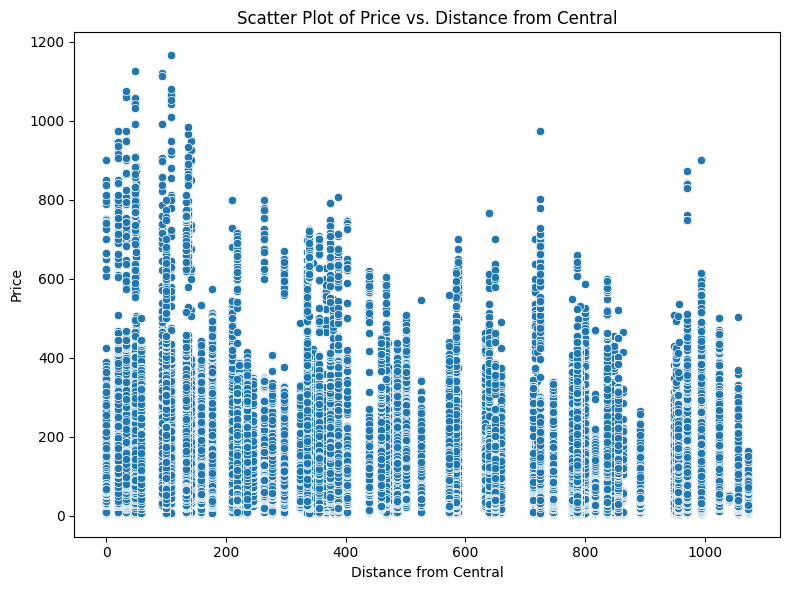

In [ ]:
df_cleaned['price'] = pd.to_numeric(df_cleaned['price'], errors='coerce')
df_cleaned['distance_from_central'] = pd.to_numeric(df_cleaned['distance_from_central'], errors='coerce')
df_corr = df_cleaned[['price', 'distance_from_central']].dropna()

correlation_value = df_corr['price'].corr(df_corr['distance_from_central'])
print("Correlation between price and distance_from_central:", correlation_value)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_corr, x='distance_from_central', y='price')
plt.title("Scatter Plot of Price vs. Distance from Central")
plt.xlabel("Distance from Central")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


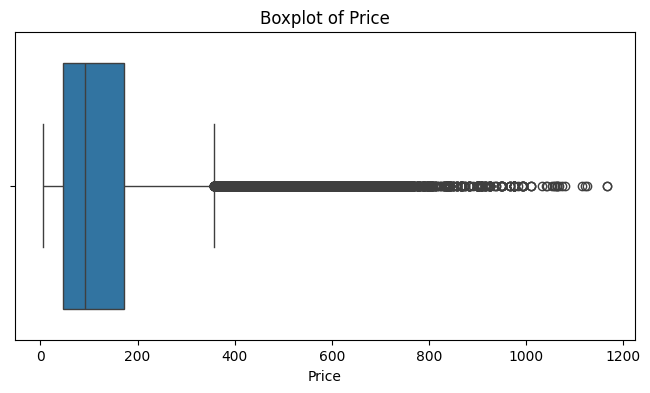

Skewness: 2.301
Excess Kurtosis: 7.643


In [ ]:
data = df_cleaned['price']
plt.figure(figsize=(8, 4))
sns.boxplot(x=data)
plt.title("Boxplot of Price")
plt.xlabel("Price")
plt.show()

skewness = data.skew()
kurtosis = data.kurtosis()  # excess kurtosis (normal is 0)
print(f"Skewness: {skewness:.3f}")
print(f"Excess Kurtosis: {kurtosis:.3f}")

We got heavy skewness as well as high kurtosis so we'll do log transformation to reduce this skewness and tail heaviness before computing distances.

Checking for new skewness and kurtosis after doing log transformation

Skewness of log-transformed price: -0.333
Excess kurtosis of log-transformed price: 0.152


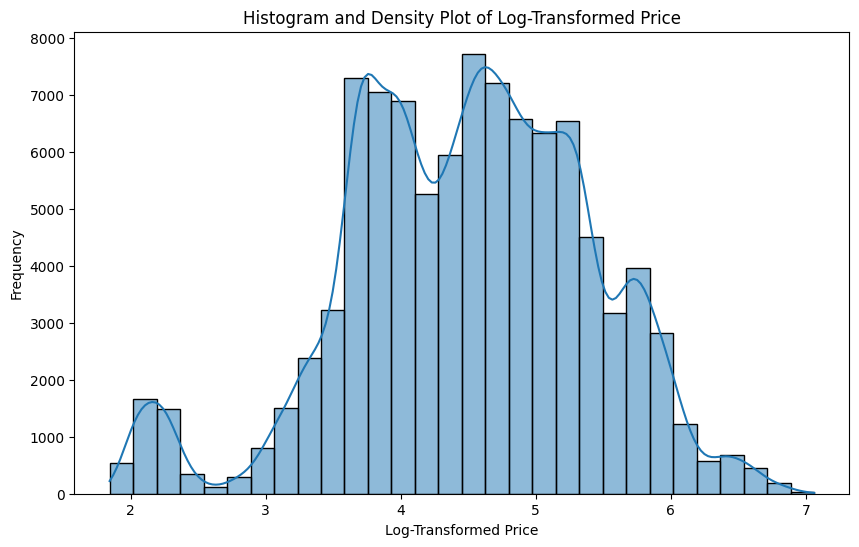

In [ ]:
df_cleaned['price_log'] = np.log1p(df_cleaned['price'])
price_log = df_cleaned['price_log'].dropna()
price_skewness = skew(price_log)
price_excess_kurtosis = kurtosis(price_log)

print(f"Skewness of log-transformed price: {price_skewness:.3f}")
print(f"Excess kurtosis of log-transformed price: {price_excess_kurtosis:.3f}")

plt.figure(figsize=(10, 6))
sns.histplot(price_log, bins=30, kde=True)
plt.title("Histogram and Density Plot of Log-Transformed Price")
plt.xlabel("Log-Transformed Price")
plt.ylabel("Frequency")
plt.show()


Using manhattan due to the presence of outliers

### Distance matrix

To capture the evolution of price over time, use time-specific averages

Yearly average log-transformed price by category:
             category  year  price_log
0  cereals and tubers  2020   3.784927
1  cereals and tubers  2021   3.789856
2  cereals and tubers  2022   3.825075
3  cereals and tubers  2023   3.928745
4  cereals and tubers  2024   4.045053

Pivoted DataFrame (yearly averages):
category  cereals and tubers  meat, fish and eggs  pulses and nuts  \
year                                                                 
2020                3.784927             4.906672         4.566251   
2021                3.789856             5.011648         4.601264   
2022                3.825075             5.079351         4.638564   
2023                3.928745             5.128980         4.661388   
2024                4.045053             5.137186         4.669527   

category  vegetables and fruits  
year                             
2020                   4.144435  
2021                   4.205727  
2022                   4.263098  
2023             

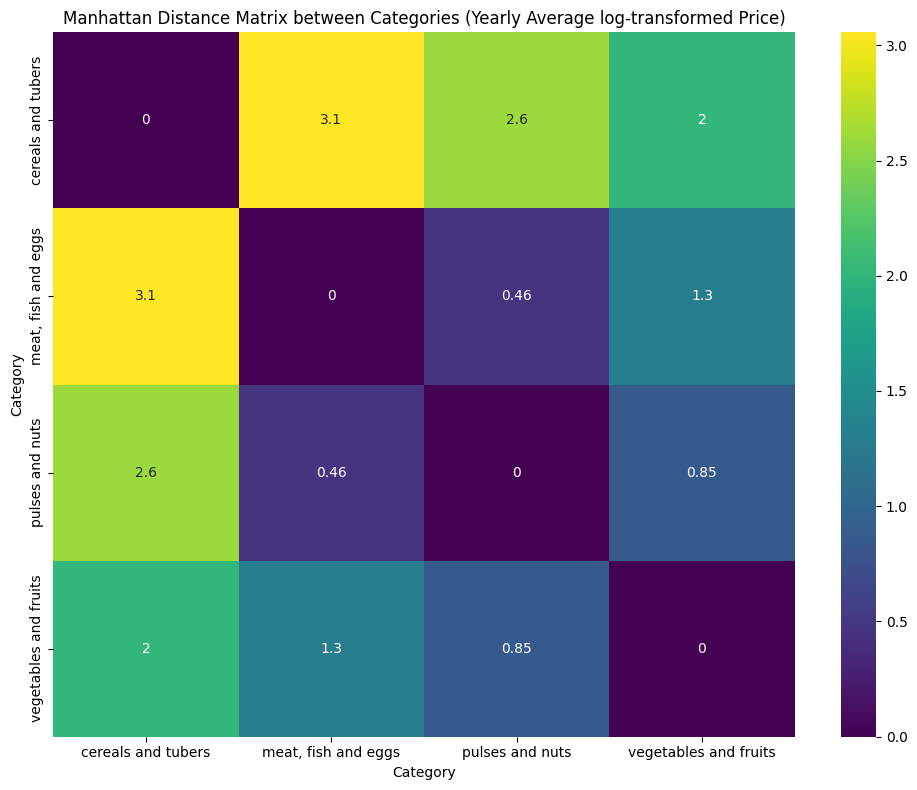


Ranking of closest distances between categories (based on log-transformed price):
                category            category2  distance
0        pulses and nuts  meat, fish and eggs  0.456563
1  vegetables and fruits      pulses and nuts  0.854655
2  vegetables and fruits  meat, fish and eggs  1.289435
3  vegetables and fruits   cereals and tubers  2.006905
4        pulses and nuts   cereals and tubers  2.599544
5    meat, fish and eggs   cereals and tubers  3.056107


In [9]:
df_cleaned['year'] = df_cleaned['date'].dt.year

if 'price_log' not in df_cleaned.columns:
    df_cleaned['price_log'] = np.log1p(df_cleaned['price'])

avg_by_category_year = df_cleaned.groupby(['category', 'year'])['price_log'].mean().reset_index()
print("Yearly average log-transformed price by category:")
print(avg_by_category_year.head())
pivot_df = avg_by_category_year.pivot(index='year', columns='category', values='price_log')

print("\nPivoted DataFrame (yearly averages):")
print(pivot_df.head())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)
scaled_categories = scaled_data.T  

dist_matrix = squareform(pdist(scaled_categories, metric='cityblock'))

dist_df = pd.DataFrame(dist_matrix, index=pivot_df.columns, columns=pivot_df.columns)

print("\nManhattan distance matrix between categories (based on yearly average log-transformed price):")
print(dist_df)

plt.figure(figsize=(10,8))
sns.heatmap(dist_df, annot=True, cmap='viridis')
plt.title("Manhattan Distance Matrix between Categories (Yearly Average log-transformed Price)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

dist_df.index.name = 'category'
dist_long = dist_df.reset_index().melt(id_vars='category', var_name='category2', value_name='distance')
dist_long = dist_long[dist_long['category'] != dist_long['category2']]
dist_long['pair'] = dist_long.apply(lambda row: tuple(sorted([row['category'], row['category2']])), axis=1)
dist_long_unique = dist_long.drop_duplicates(subset='pair').drop(columns='pair')
ranked_distances = dist_long_unique.sort_values(by='distance').reset_index(drop=True)

print("\nRanking of closest distances between categories (based on log-transformed price):")
print(ranked_distances)


Yearly average log-transformed price by region:
                                 admin1  year  price_log
0  Autonomous region in Muslim Mindanao  2020   4.129112
1  Autonomous region in Muslim Mindanao  2021   4.112581
2  Autonomous region in Muslim Mindanao  2022   4.219660
3  Autonomous region in Muslim Mindanao  2023   4.238949
4  Autonomous region in Muslim Mindanao  2024   4.191901
admin1  Autonomous region in Muslim Mindanao  \
year                                           
2020                                4.129112   
2021                                4.112581   
2022                                4.219660   
2023                                4.238949   
2024                                4.191901   

admin1  Cordillera Administrative region  National Capital region  Region I  \
year                                                                          
2020                            4.434264                 4.563356  4.391132   
2021                            4.46

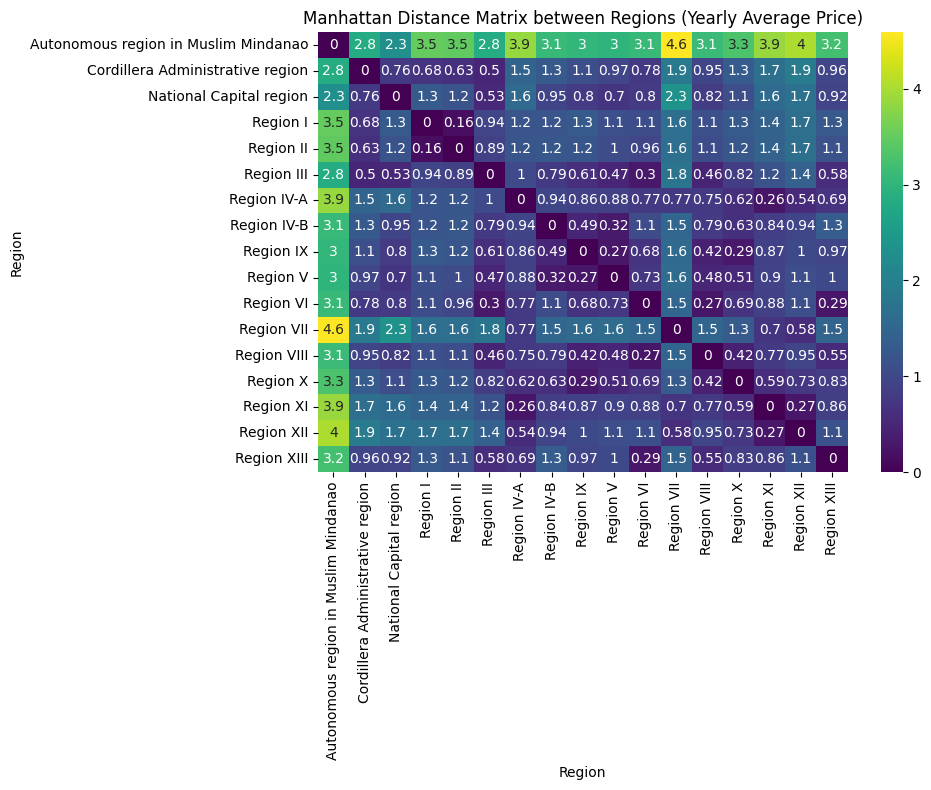


Ranking of closest distances between regions (based on yearly average log-transformed price):
          region                               region2  distance
0      Region II                              Region I  0.161330
1      Region XI                           Region IV-A  0.263338
2    Region VIII                             Region VI  0.266465
3       Region V                             Region IX  0.269599
4     Region XII                             Region XI  0.274661
..           ...                                   ...       ...
131     Region I  Autonomous region in Muslim Mindanao  3.512750
132  Region IV-A  Autonomous region in Muslim Mindanao  3.866963
133    Region XI  Autonomous region in Muslim Mindanao  3.886080
134   Region XII  Autonomous region in Muslim Mindanao  4.028618
135   Region VII  Autonomous region in Muslim Mindanao  4.590100

[136 rows x 3 columns]


In [ ]:
avg_by_region_year = df_cleaned.groupby(['admin1', 'year'])['price_log'].mean().reset_index()
print("Yearly average log-transformed price by region:")
print(avg_by_region_year.head())

pivot_df = avg_by_region_year.pivot(index='year', columns='admin1', values='price_log')

print(pivot_df.head())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)  
scaled_regions = scaled_data.T  # shape: (n_regions, n_years)

dist_matrix = squareform(pdist(scaled_regions, metric='cityblock'))
dist_df = pd.DataFrame(dist_matrix, index=pivot_df.columns, columns=pivot_df.columns)
dist_df.index.name = 'region'

print("\nManhattan distance matrix between regions (based on yearly average log-transformed price):")
print(dist_df)

plt.figure(figsize=(10,8))
sns.heatmap(dist_df, annot=True, cmap='viridis')
plt.title("Manhattan Distance Matrix between Regions (Yearly Average Price)")
plt.xlabel("Region")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

dist_long = dist_df.reset_index().melt(id_vars='region', var_name='region2', value_name='distance')
dist_long = dist_long[dist_long['region'] != dist_long['region2']]
dist_long['pair'] = dist_long.apply(lambda row: tuple(sorted([row['region'], row['region2']])), axis=1)
dist_long_unique = dist_long.drop_duplicates(subset='pair').drop(columns='pair')

ranked_distances = dist_long_unique.sort_values(by='distance').reset_index(drop=True)
print("\nRanking of closest distances between regions (based on yearly average log-transformed price):")
print(ranked_distances)
